In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

# Step 1: Load player participation data
pp = pd.read_csv("nfl_player_participation_2020_present.csv")

# Step 2: Keep only relevant columns
pp = pp[['nflverse_game_id', 'play_id', 'offense_players', 'defense_players','epa']]

# Step 5: Drop plays with missing player info or EPA
df = pp.dropna(subset=['offense_players', 'defense_players', 'epa'])

# Step 6: Parse player IDs into lists
df['offense_list'] = df['offense_players'].str.split(';')
df['defense_list'] = df['defense_players'].str.split(';')

# Step 7: Get list of all unique players
all_players = set(p for lst in df['offense_list'] for p in lst)
all_players.update(p for lst in df['defense_list'] for p in lst)
all_players = sorted(all_players)

# Step 8: Build ra_epa design matrix
X = pd.DataFrame(0, index=df.index, columns=all_players)

for i, row in df.iterrows():
    for pid in row['offense_list']:
        if pid in X.columns:
            X.loc[i, pid] = 1
    for pid in row['defense_list']:
        if pid in X.columns:
            X.loc[i, pid] = -1


# Step 9: Define target variable
y = df['epa'].values


/var/folders/lh/nvm57cpn2yxbb6dh026mnts40000gp/T/ipykernel_95034/2471606924.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['offense_list'] = df['offense_players'].str.split(';')
/var/folders/lh/nvm57cpn2yxbb6dh026mnts40000gp/T/ipykernel_95034/2471606924.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['defense_list'] = df['defense_players'].str.split(';')


KeyboardInterrupt: 

In [ ]:

# Step 9: Define target variable
y = df['epa'].values

# Step 10: Fit Ridge Regression
ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X, y)

# Step 11: Output ra_epa coefficients
ra_epa = pd.Series(ridge.coef_, index=X.columns).sort_values(ascending=False)

# Step 12: Optional – Map player IDs to names
# Load a player metadata file with columns: gsis_id (or nfl_id), player_name
# players = pd.read_csv('players.csv')
# ra_epa_named = ra_epa.reset_index().merge(players, left_on='index', right_on='gsis_id', how='left')

print(ra_epa.head(20))  # Top players by ra_epa

/Users/riley.gisseman/Downloads/cfb_nfl_dev_env/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riley.gisseman/Downloads/cfb_nfl_dev_env/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riley.gisseman/Downloads/cfb_nfl_dev_env/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


00-0032703    1.280376
00-0031646    1.260818
00-0036562    1.159304
00-0034705    1.104669
00-0037122    0.929502
00-0029415    0.827232
00-0033345    0.784744
00-0034811    0.746475
00-0035845    0.680691
00-0033972    0.667409
00-0035597    0.655692
00-0037460    0.617335
00-0021678    0.596817
00-0038633    0.595066
00-0038737    0.594582
00-0037637    0.593536
00-0034664    0.587256
00-0034207    0.586972
00-0038654    0.576417
00-0033965    0.549546
dtype: float64


In [ ]:
# Step 1: Flatten offense and defense into a long list of (play index, player ID)
from collections import Counter

# Combine all player appearances
all_appearances = []

for i, row in df.iterrows():
    all_appearances.extend((pid, i) for pid in row['offense_list'])
    all_appearances.extend((pid, i) for pid in row['defense_list'])

# Step 2: Count how many plays each player was in
# Only count unique plays, to avoid duplicates
player_counts = Counter(pid for pid, _ in all_appearances)

# Step 3: Multiply ra_epa coefficient × play count
ra_epa_impact = ra_epa.multiply(pd.Series(player_counts)).sort_values(ascending=False)

# Optional: put into a dataframe for easier viewing
ra_epa_df = pd.DataFrame({
    'ra_epa_per_play': ra_epa,
    'play_count': pd.Series(player_counts),
    'ra_epa_total_impact': ra_epa_impact
}).fillna(0).reset_index().rename(columns={'index': 'gsis_id'})

players = pd.read_csv("nfl_players.csv")

ra_epa_with_names = ra_epa_df.merge(players[['gsis_id', 'display_name','position_group']], on='gsis_id', how='left')


In [ ]:
print(ra_epa_with_names)
ra_epa_with_names.to_csv('nfl_RA-EPA.csv')

         gsis_id  ra_epa_per_play  play_count  ra_epa_total_impact  \
0     00-0004091        -0.130500         302           -39.411142   
1     00-0016919         0.054190         284            15.390096   
2     00-0019596        -0.096874        8912          -863.338960   
3     00-0019646        -0.126606         330           -41.779878   
4     00-0019714        -0.022664         325            -7.365799   
...          ...              ...         ...                  ...   
5015  00-0039163        -0.022765         965           -21.967987   
5016  00-0039164        -0.188945         177           -33.443242   
5017  00-0039165         0.009361         491             4.596401   
5018  00-0039167         0.107692         820            88.307545   
5019  00-0039169         0.062934         799            50.284232   

              display_name position_group  
0              Phil Dawson           SPEC  
1           Adam Vinatieri           SPEC  
2                Tom Brady 

Initial results when relative to positional 300 snap replacement player:

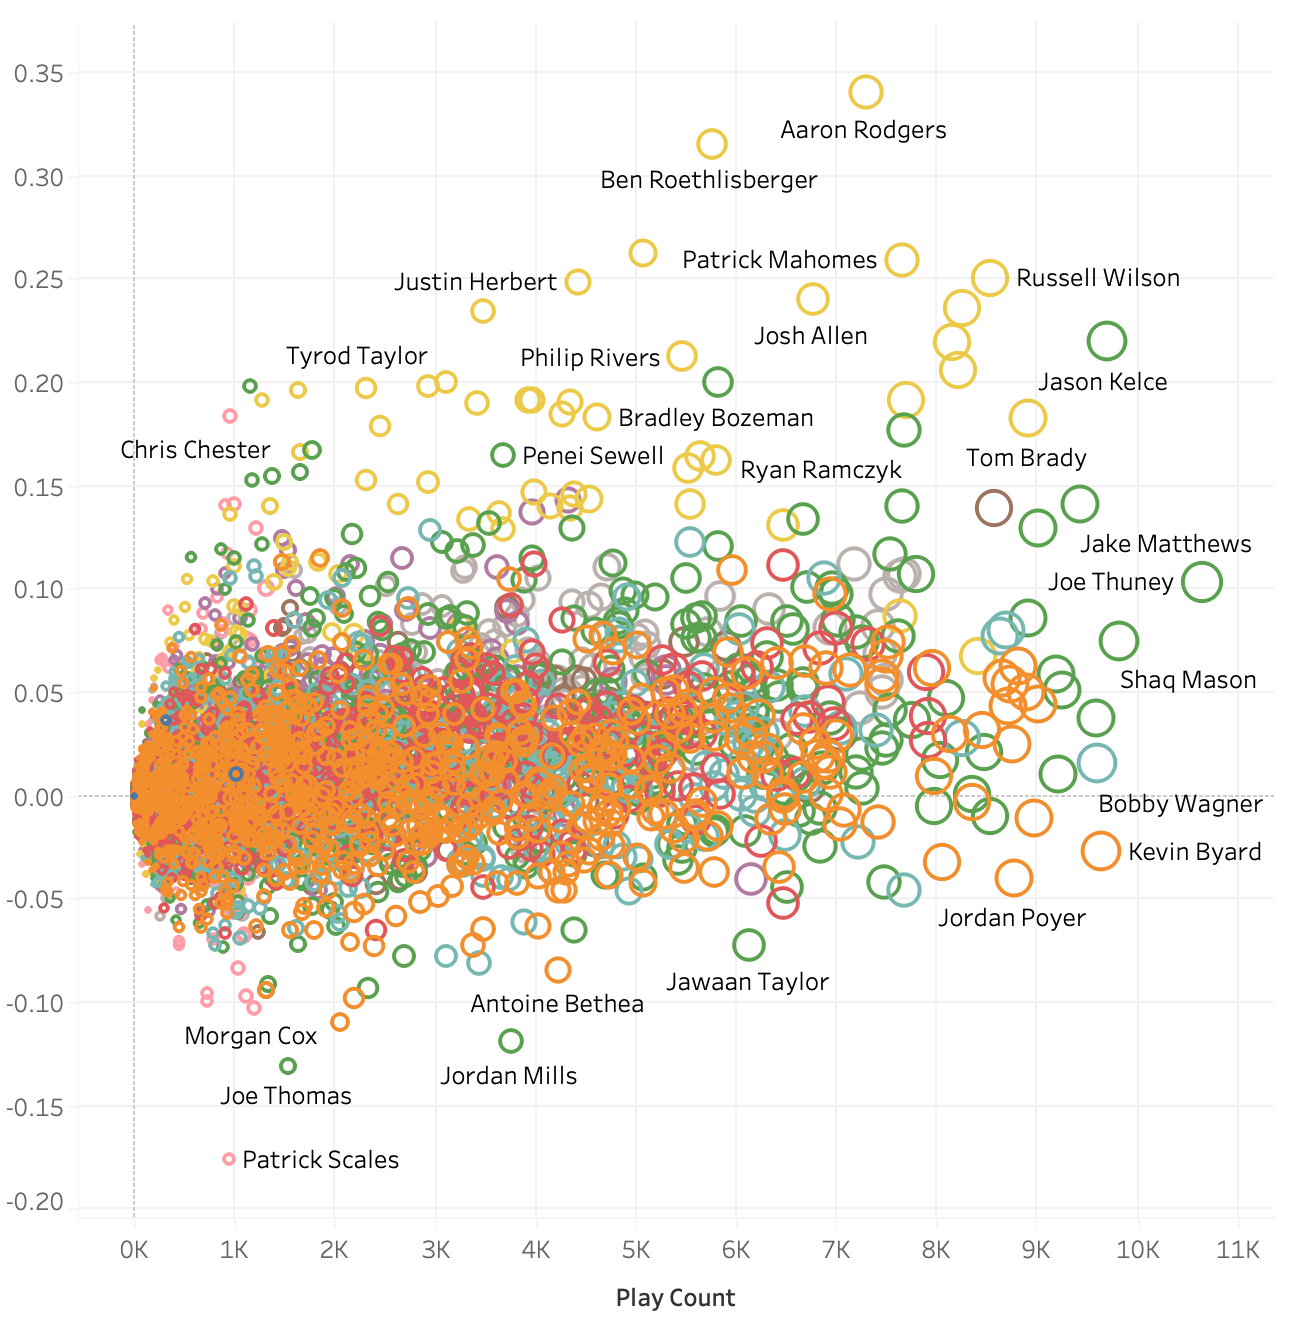